# Transformer Training

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

from transformer_model_GPU import *
import nltk
import sys
import matplotlib.pyplot as plt
sys.path.append("../../..")

from statapp.common.preprocessing import load_all_data, encode_data, split_into_X_y

from statapp.common.sampling import sample_token_sequence

import time

import pickle

USE_CUDA = False

### Selection GPU

In [2]:
USE_CUDA = True

In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
torch.cuda.device(0)
torch.cuda.get_device_name(0)

'GeForce GTX 1050'

In [5]:
torch.cuda.set_device(0)

In [6]:
device = "cuda:0" 

## Preprocessing

Preprocessing maison assez brouillon pour le moment... L'encodage est effectué au niveau des mots. Les données exploitées sont placées dans le dossier data dans le dossier du notebook.

In [7]:
# Choisir proportion multiple de 0.05

def build_vocab(vocab_size=10000, proportion=0.1):
    
    dico = {}
    
    step = int(proportion*100//5)
    
    for i in range(step):
        
        text = load_all_data("data/fr.train.top1M.txt", start=i*0.05, sample=0.05)
        tokens = nltk.word_tokenize(text)
        vocab = list(set(tokens))
        vocab.sort()
        
        for word in vocab:
            if word not in dico.keys():
                dico[word]=0

        for token in tokens:
            dico[token]+=1

    sorted_list = sorted(dico.items(), key=lambda x: x[1], reverse=True)

    sorted_dico = {}

    for i in range(min(len(sorted_list),vocab_size-1)):
        sorted_dico[sorted_list[i][0]] = sorted_list[i][1]        
    
    vocab = list(sorted_dico.keys())
    vocab.append("<unk>")
    vocab.sort()  
    
    return vocab

In [8]:
vocab = build_vocab(vocab_size=5000, proportion=0.1)

In [8]:
def load_data_train(start, sample, vocab):
    
    text = load_all_data("data/fr.train.top1M.txt", start=start, sample=sample)
    tokens = nltk.word_tokenize(text)
    
    for i in range(len(tokens)):
        if tokens[i] not in vocab:
            tokens[i] = "<unk>"       

    vocab_numbers = dict(zip(vocab, range(0,len(vocab))))
    tokens_numbers = np.array([vocab_numbers[tokens[i]] for i in range(len(tokens))])
    tokens_numbers_sequences = np.array([ tokens_numbers[i:i+max_length+1] for i in range(len(tokens_numbers)-max_length)])
    tokens_numbers_sequences = torch.tensor(tokens_numbers_sequences , dtype=torch.int64)
    
    #if USE_CUDA:
    #    tokens_numbers_sequences.to(device)
    
    return tokens_numbers_sequences

In [10]:
"""
vocab = list(set(tokens))

if "<unk>" not in vocab:
    vocab.append("<unk>")
    
vocab.sort()
    
vocab_size = len(vocab)

vocab_numbers = dict(zip(vocab, range(0,len(vocab))))
vocab_numeroted = dict(zip(range(0,len(vocab)), vocab))
tokens_numbers = np.array([vocab_numbers[tokens[i]] for i in range(len(tokens))])

tokens_numbers_sequences = np.array([ tokens_numbers[i:i+max_length+1] for i in range(len(tokens_numbers)-max_length)])
tokens_numbers_sequences = torch.tensor(tokens_numbers_sequences , dtype=torch.int64)

nb_sequences =  tokens_numbers_sequences.shape[0]

print("Les données exploitées contiennent {} tokens (mots) au total.".format(len(tokens)))
print("La taille du vocabulaire ainsi constitué est de {}".format(vocab_size))
"""

'\nvocab = list(set(tokens))\n\nif "<unk>" not in vocab:\n    vocab.append("<unk>")\n    \nvocab.sort()\n    \nvocab_size = len(vocab)\n\nvocab_numbers = dict(zip(vocab, range(0,len(vocab))))\nvocab_numeroted = dict(zip(range(0,len(vocab)), vocab))\ntokens_numbers = np.array([vocab_numbers[tokens[i]] for i in range(len(tokens))])\n\ntokens_numbers_sequences = np.array([ tokens_numbers[i:i+max_length+1] for i in range(len(tokens_numbers)-max_length)])\ntokens_numbers_sequences = torch.tensor(tokens_numbers_sequences , dtype=torch.int64)\n\nnb_sequences =  tokens_numbers_sequences.shape[0]\n\nprint("Les données exploitées contiennent {} tokens (mots) au total.".format(len(tokens)))\nprint("La taille du vocabulaire ainsi constitué est de {}".format(vocab_size))\n'

In [20]:
"""
#Constitution d'un jeu de test numéroté selon le vocabulaire du jeu d'entrainement

text_test = load_all_data("data/fr.train.top1M.txt", start=0.9, sample=0.1)

tokens_test = nltk.word_tokenize(text_test)

for i in range(len(tokens_test)):
    if tokens_test[i] not in vocab:
        tokens_test[i] = "<unk>"

tokens_numbers_test = np.array([vocab_numbers[tokens_test[i]] for i in range(len(tokens_test))])

tokens_numbers_sequences_test = np.array([ tokens_numbers_test[i:i+max_length+1] for i in range(len(tokens_numbers_test)-max_length)])
tokens_numbers_sequences_test = torch.tensor(tokens_numbers_sequences_test , dtype=torch.int64)

nb_sequences_test =  tokens_numbers_sequences_test.shape[0]

print("Les données de test exploitées contiennent {} tokens (mots) au total.".format(len(tokens_test)))
"""

'\n#Constitution d\'un jeu de test numéroté selon le vocabulaire du jeu d\'entrainement\n\ntext_test = load_all_data("data/fr.train.top1M.txt", start=0.9, sample=0.1)\n\ntokens_test = nltk.word_tokenize(text_test)\n\nfor i in range(len(tokens_test)):\n    if tokens_test[i] not in vocab:\n        tokens_test[i] = "<unk>"\n\ntokens_numbers_test = np.array([vocab_numbers[tokens_test[i]] for i in range(len(tokens_test))])\n\ntokens_numbers_sequences_test = np.array([ tokens_numbers_test[i:i+max_length+1] for i in range(len(tokens_numbers_test)-max_length)])\ntokens_numbers_sequences_test = torch.tensor(tokens_numbers_sequences_test , dtype=torch.int64)\n\nnb_sequences_test =  tokens_numbers_sequences_test.shape[0]\n\nprint("Les données de test exploitées contiennent {} tokens (mots) au total.".format(len(tokens_test)))\n'

In [21]:
"""
if USE_CUDA:
    tokens_numbers_sequences.to(device)
    tokens_numbers_sequences_test.to(device)
"""

'\nif USE_CUDA:\n    tokens_numbers_sequences.to(device)\n    tokens_numbers_sequences_test.to(device)\n'

# Attention Creation Fichier Data

On créé des fichiers contenant 5% du data set initial, vocabulaire taille 20K et etendu=5 (voir train)

In [16]:
"""

for i in range(20):
    name = "Taille5_Voca20K_" + str(i)
    with open(name,'wb') as fichier:
        mon_pickler = pickle.Pickler(fichier)
        mon_pickler.dump(load_data_train(i*0.05, 0.05, vocab))
        
"""

KeyboardInterrupt: 

## Apprentissage du modèle

In [11]:
vocab_size = len(vocab)

In [12]:
LMtransformer = buildTransformer(vector_size, nb_decoders, nb_heads, head_size, ffn_hidden_size, vocab_size)
if USE_CUDA:
    LMtransformer.to(device)

#Correspond à utiliser l'entropie croisée puisque les sorties sont des log_softmax
#et l'entropie croisée = nll_loss(log_softmax(.), target)
criterion = nn.NLLLoss()
optimizer = optim.Adam(LMtransformer.parameters(), lr=0.01)

In [13]:
def train_model(nb_epochs, batch_size, proportion):
    
    #What is this ?? I don't remember. Make grad required ?
    LMtransformer.train()
    
    epochs_losses = []
    losses = []
    test_losses = []
    
    start = time.time()
    
    etendu = 5
    
    for epoch in range(nb_epochs):
        
        running_loss = 0
        
        print("Test epoch : ", epoch)
        
    
        for step in range(int(proportion*100//etendu)):
            
            print("Test step 1 : ", step)
            
            """
            
            name = "Taille5_Voca20K_" + str(step)
            with open(name,'rb') as fichier:
                mon_depickler = pickle.Unpickler(fichier)
                tokens_numbers_sequences = mon_depickler.load()   
                
            """
            
            tokens_numbers_sequences =load_data_train(step*0.05, 0.05, vocab)
            
       
            if USE_CUDA:
                tokens_numbers_sequences.to(device) 
                
            nb_sequences =  tokens_numbers_sequences.shape[0]
        
            randperm = torch.randperm(nb_sequences)
            randperm = randperm[:(nb_sequences//batch_size)*batch_size]
            batchs_indices = randperm.reshape(nb_sequences//batch_size, batch_size)
            
            print("Test step 2 : ", step)

            for i, batch_indices in enumerate(batchs_indices):

                batch = (tokens_numbers_sequences[batch_indices]).to(device)
                optimizer.zero_grad()
                output = LMtransformer(batch[:,:-1])
                loss = criterion(output.reshape(-1, vocab_size), batch[:,1:].flatten())

                loss.backward()
                optimizer.step()

                test_loss = 0

                #Il faudrait adapter les affichages en fonction du nombre de batchs total
                running_loss += loss.item()
                
                
                

                #Calcul de la loss sur les données de test
                """
                if USE_CUDA:
                    test_output = (LMtransformer(tokens_numbers_sequences_test[:,:-1])).cuda()
                    test_loss = criterion(test_output.reshape(-1, vocab_size), tokens_numbers_sequences_test[:,1:].flatten())
                else:
                    test_output = LMtransformer(tokens_numbers_sequences_test[:,:-1])  
                    test_loss = criterion(test_output.reshape(-1, vocab_size), tokens_numbers_sequences_test[:,1:].flatten())

                print('[%d, %5d] loss: %.3f ; test_loss : %.3f' %
                        (epoch + 1, i + 1, running_loss / step, test_loss))
                """
            
            nb_batches_in_the_step = nb_sequences//batch_size

            print('[%d, %5d] loss: %.3f ' %
                (epoch + 1, i + 1, running_loss / nb_batches_in_the_step))
                    
            #stock pour affichage graphique
            epochs_losses.append(epoch-1+step)
            losses.append(running_loss / nb_batches_in_the_step)                    
                    
            #test_losses.append(test_loss)

            running_loss = 0.

            end = time.time()
            print("Temps : ", end-start)

    plt.plot(epochs_losses, losses)
    #plt.plot(epochs_losses, test_losses)

Test d'overfitting sur un cas ultrasimplifié (5 tokens, longueur de séquence 1, 3 decoders, 2 heads) :
- En observant les sorties le modèle a bien appris et overfitte ! (loss à 0 au bout de 5-6 epochs) 

Test epoch :  0
Test step 1 :  0
Test step 2 :  0


C:\Users\Christos\Desktop\Git\statapp_language_model\statapp\transformer\pytorch\transformer_model_GPU.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = (torch.tensor(torch.add(embedded, pos_encodings), dtype=torch.float32)).to(device)


[1,  6315] loss: 4.025 
Temps :  509.0999028682709
Test step 1 :  1
Test step 2 :  1
[1,  6308] loss: 3.944 
Temps :  1013.5090925693512


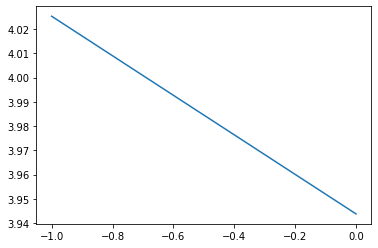

In [14]:
train_model(1,400,0.1)

Test 1 step :  0
Test 2 step :  0
Test 1 step :  1
Test 2 step :  1
[1] loss: 3.953 
Temps :  407.90645027160645


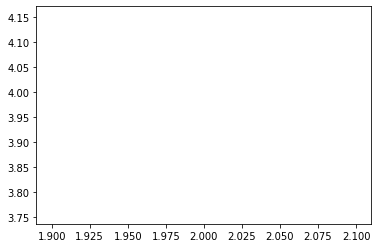

In [33]:
"""

# Train Loss

n = 1
batch_size = 400

epochs_losses = []
train_losses = []
    
start = time.time()
    
for epoch in range(n):
    
    running_loss = 0
    nb_batches_in_the_epoch = 0
    
    for step in range(int(0.1*100//5)):

        print("Test 1 step : ", step)

        tokens_numbers_sequences = load_data_train(step*0.05, 0.05, vocab)

        if USE_CUDA:
            tokens_numbers_sequences.to(device) 

        nb_sequences =  tokens_numbers_sequences.shape[0]

        randperm = torch.randperm(nb_sequences)
        randperm = randperm[:(nb_sequences//batch_size)*batch_size]
        batchs_indices = randperm.reshape(nb_sequences//batch_size, batch_size)

        print("Test 2 step : ", step)

        for i, batch_indices in enumerate(batchs_indices):
            batch = (tokens_numbers_sequences[batch_indices]).to(device)
            output = LMtransformer(batch[:,:-1])
            loss = criterion(output.reshape(-1, vocab_size), batch[:,1:].flatten())
            running_loss += loss.item()

        nb_batches_in_the_epoch += nb_sequences//batch_size

    print('[%d] loss: %.3f ' %
        (epoch + 1, running_loss / nb_batches_in_the_epoch))

    epochs_losses.append(n+1)
    train_losses.append(running_loss / nb_batches_in_the_epoch)                    

    end = time.time()
    print("Temps : ", end-start)

plt.plot(epochs_losses, train_losses)

"""

## Calcul Erreur de test

In [9]:
vocab = torch.load("params/vocabData90percentSize30k", map_location=torch.device('cpu'))
vocab_size = len(vocab)
vocab_numbers = dict(zip(vocab, range(0,len(vocab))))
vocab_numeroted = dict(zip(range(0,len(vocab)), vocab))

In [11]:
# Test Loss

nb_epoch = 1
batch_size = 400
proportion = 0.1
start = 0.9


epochs_losses = []
test_losses = []
    
begin = time.time()
    
for epoch in range(nb_epoch):
    
    name_model = "params/LMtfparamsData90percentBatch512epoch" + str(epoch+1)
    lp = torch.load(name_model, map_location=torch.device('cuda:0'))
    nb_decoders = lp["nb_decoders"]
    vector_size = lp["vector_size"]
    nb_heads = lp["nb_heads"]
    head_size = lp["head_size"]
    max_length = lp["max_length"]
    ffn_hidden_size = lp["ffn_hidden_size"]
    vocab_size = lp["vocab_size"]
    model_params_dict = lp["model_params_dict"]

    LMtransformer = buildTransformer(vector_size, nb_decoders, nb_heads, head_size, ffn_hidden_size, vocab_size)
    LMtransformer.load_state_dict(model_params_dict)
    
    criterion = nn.NLLLoss()
    
    test_loss = 0
    nb_batches_in_the_epoch = 0
    
    for step in range(int(proportion*100//5)):

        print("Test 1 step : ", step)

        tokens_numbers_sequences_test = load_data_train(start + step*0.05, 0.05, vocab)

        if USE_CUDA:
            tokens_numbers_sequences_test.to(device) 

        nb_sequences_test =  tokens_numbers_sequences_test.shape[0]

        randperm = torch.randperm(nb_sequences_test)
        randperm = randperm[:(nb_sequences_test//batch_size)*batch_size]
        batchs_indices = randperm.reshape(nb_sequences_test//batch_size, batch_size)

        print("Test 2 step : ", step)

        for i, batch_indices in enumerate(batchs_indices):
            batch = (tokens_numbers_sequences_test[batch_indices]).to(device)
            output = LMtransformer(batch[:,:-1])
            loss = criterion(output.reshape(-1, vocab_size), batch[:,1:].flatten())
            test_loss += loss.item()

        nb_batches_in_the_epoch += nb_sequences_test//batch_size

    print('[%d] loss: %.3f ' %
        (epoch + 1, test_loss / nb_batches_in_the_epoch))

    epochs_losses.append(epoch+1)
    test_losses.append(test_loss / nb_batches_in_the_epoch)                    

    end = time.time()
    print("Temps : ", end-begin)

plt.plot(epochs_losses, test_losses)

Test 1 step :  0
Test 2 step :  0


C:\Users\Christos\Desktop\Git\statapp_language_model\statapp\transformer\pytorch\transformer_model_GPU.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = (torch.tensor(torch.add(embedded, pos_encodings), dtype=torch.float32)).to(device)


NameError: name 'criterion' is not defined

## Sauvegarde des paramètres du modèle obtenu

In [15]:
"""

#Un dico  des hyperparams serait pratique ^^
torch.save({
    "nb_decoders" : nb_decoders,
    "vector_size" : vector_size,
    "nb_heads" : nb_heads,
    "head_size" : head_size,
    "max_length" : max_length,
    "ffn_hidden_size" : ffn_hidden_size,
    "vocab_size" : vocab_size,
    "model_params_dict" : LMtransformer.state_dict()}
    ,
    "params/LMtfparamsTEST")
    #"params/LMtfparams"+str(np.random.rand())[2:])
    
"""

In [8]:
"""

#Later to restore:
lp = torch.load("params/LMtfparamsTEST")

nb_decoders = lp["nb_decoders"]
vector_size = lp["vector_size"]
nb_heads = lp["nb_heads"]
head_size = lp["head_size"]
max_length = lp["max_length"]
ffn_hidden_size = lp["ffn_hidden_size"]
vocab_size = lp["vocab_size"]
model_params_dict = lp["model_params_dict"]

LMtransformerTEST = buildTransformer(vector_size, nb_decoders, nb_heads, head_size, ffn_hidden_size, vocab_size)
LMtransformerTEST.load_state_dict(model_params_dict)

#Attention, pour pouvoir générer il faut reconstruire le vocabulaire et ses numéros associés avec le code plus haut

"""

<All keys matched successfully>

## Génération

In [12]:
vocab = torch.load("params/vocabData90percentSize30k", map_location=torch.device('cpu'))
vocab_size = len(vocab)
vocab_numbers = dict(zip(vocab, range(0,len(vocab))))
vocab_numeroted = dict(zip(range(0,len(vocab)), vocab))

In [14]:
# Selection du modèle

name_model = "params/LMtfparamsData90percentBatch512epoch" + str(1)
lp = torch.load(name_model, map_location=torch.device('cuda:0'))
nb_decoders = lp["nb_decoders"]
vector_size = lp["vector_size"]
nb_heads = lp["nb_heads"]
head_size = lp["head_size"]
max_length = lp["max_length"]
ffn_hidden_size = lp["ffn_hidden_size"]
vocab_size = lp["vocab_size"]
model_params_dict = lp["model_params_dict"]

LMtransformer = buildTransformer(vector_size, nb_decoders, nb_heads, head_size, ffn_hidden_size, vocab_size)
LMtransformer.load_state_dict(model_params_dict)

<All keys matched successfully>

In [20]:
def LMtransformerprediction(listints):
    res = (torch.tensor([listints[-max_length:]])).cuda()
    return np.exp(LMtransformer(res)[0][-1].tolist())

def gen_seq(prev_seq, top_k=5):
    with torch.no_grad():
        prev_seq_numbers = [vocab_numbers[token] for token in prev_seq]
        sample_token_seq = sample_token_sequence(LMtransformerprediction, prev_seq_numbers, top_k=top_k)
        tokens_pred = [vocab_numeroted[i] for i in sample_token_seq]
        print(' '.join(tokens_pred)) 

In [25]:
def LMtransformerpredictionwithoutUNK(listints):
    res = (torch.tensor([listints[-max_length:]])).cuda()
    probas = np.exp(LMtransformer(res)[0][-1].tolist())
    probas[vocab_numbers["<unk>"]]=0
    return probas

def gen_seqwithoutUNK(prev_seq, top_k=5):
    with torch.no_grad():
        prev_seq_numbers = [vocab_numbers[token] for token in prev_seq]
        sample_token_seq = sample_token_sequence(LMtransformerpredictionwithoutUNK, prev_seq_numbers, top_k=top_k)
        tokens_pred = [vocab_numeroted[i] for i in sample_token_seq]
        print(' '.join(tokens_pred))


In [29]:
gen_seq(['a','l','age','de','31','ans'])

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 57.03it/s]


. il est ensuite nomme commandant d ' un <unk> de la famille <unk> . <unk> <unk> , le <unk> et le <unk> , le gouvernement <unk> , qui s ' etend au cours du monde `` ( <unk> <unk> ) . <unk> <unk> <unk> , <unk> , <unk> et <unk> , <unk> <unk> <unk> , <unk> , <unk> , <unk> , <unk> et <unk> , les <unk> , les <unk> et les autres <unk> <unk> , en particulier . le <unk> est une voie de la societe francaise , le <unk> est <unk> , <unk> , en <unk> ,


In [30]:
gen_seq(['a','l','age','de','31','ans'], top_k=1)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 55.16it/s]


, <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk>


In [27]:
gen_seqwithoutUNK(['a','l','age','de','31','ans'])

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.90it/s]


, le `` `` est le premier ministre . en avril 2007 , la meme annee , le nombre de personnes et les premiers resultats des deux autres pays voisins de la mer . le lendemain , il se rend a la suite de la ceinture principale de la ceinture principale d ' asteroides . il est aussi possible que l ' armee , en fait une fois en europe , le plus haut de la ville de la ville . il se fait partie des annees 1960 . la commune est une espece d ' un ensemble des forces
